# Evaluating the heat treatment of milk using front-face fluorescence spectroscopy: the chemometric model and a new spectral index

## Abstract.

A readily available, fast, non-destructive front-face fluorescence technique is used as a tool for assessing heat treatment effects on milk. Spectral data on raw, pasteurized, UHT pasteurized and sterilized milk samples from a wide range of manufacturers are obtained, including reconstituted milk and its mixtures with pasteurized milk. The principal component analysis (PCA) is used to summarize all the data obtained, and a classification model is developed to distinguish between two classes of milk (1) raw and pasteurized milk and (2) milk that was exposed to high heat treatment (UHT pasteurization or sterilization), or contains products of such a treatment (dry milk). A validation procedure using a test set showed the model to be accurate to within less than 5%. A new spectral index for use in the present context, which uses the ratio of the vitamin A and Maillard reaction products peaks in fluorescence excitation spectra, is proposed and compared with the conventional FAST index.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.signal import savgol_filter as sgf


%matplotlib inline

# Rewise the raw data

In [74]:
raw_data = pd.read_excel('Milk data.xlsx', sheetname='tr')

Form a target column

In [75]:
raw_data['target'] = (raw_data['class (o)'] == 'positive') * 1

Form a list of predictors

In [76]:
raw_predictors = list(raw_data.columns.values)[3:-1]

Scale the raw_data

In [77]:
scaler = StandardScaler()
scaler.fit(raw_data[raw_predictors])

data_scaled = pd.DataFrame(data=scaler.transform(raw_data[raw_predictors]), columns=raw_predictors)

Filter the data appropriately

In [78]:
def filt_data(data, slices=None, window=25, poly=10):
    """
    data is a pre-filtered numpy ndarray matrix
    slices is a numpy ndarray of slices, e.g. [291, 441, 341]
    """
    
    # zero initialization
    data_filt = np.zeros(data.shape)
    
    if slices == None:
        data_filt = sgf(data, window_length=window, polyorder=poly, axis=1)
    elif np.sum(slices) != data.shape[1]:
        raise ValueError('sum of slices must be equal to data features')
    else:
        # pointer
        p = 0
        # filter each of slices independently
        for sl in slices:
            data_filt[:, p:p + sl] = sgf(data.as_matrix()[:, p:p + sl], window_length=window, polyorder=poly, axis=0)
            p += sl
    return data_filt

In [79]:
tryp_coef = (raw_data['359.5.1'] - (raw_data['359.1'] - raw_data['359.5.1'])) / raw_data['360.1']

raw_data#['']

,l,class,class (o),305,305.5,306,306.5,307,307.5,308,...,416.2,416.5.2,417.2,417.5.2,418.2,418.5.2,419.2,419.5.2,420.2,target
0,SOM,powdered,negative,4.101800,4.482900,4.829700,5.316200,5.760700,6.182300,6.735900,...,2.0547,2.0445,2.1874,2.1366,2.2439,2.2693,2.3901,2.3415,2.3986,0
1,SCM,powdered,negative,3.977700,4.282500,4.598500,4.971100,5.393700,5.828900,6.152600,...,2.2519,2.1822,2.1662,2.2419,2.3323,2.3597,2.4339,2.3561,2.5349,0
2,Agusha,sterilized,negative,3.249100,3.493900,3.792900,4.083300,4.279400,4.586500,4.802300,...,1.8062,1.8824,1.8777,1.9431,1.8873,1.9518,1.9752,2.0729,2.0785,0
3,Asen,pasteurized,positive,5.138500,5.516200,5.854900,6.486500,6.947700,7.500300,8.108400,...,1.5571,1.6404,1.6069,1.6352,1.5934,1.8438,1.8257,1.8647,1.9698,1
4,BJA,pasteurized,positive,5.912500,6.316900,6.873400,7.547900,7.985800,8.694900,9.379200,...,1.6285,1.6969,1.6904,1.6466,1.8339,1.8821,1.9266,1.9149,2.0668,1
5,MB,pasteurized,positive,5.148600,5.685700,5.978400,6.582900,7.136900,7.609800,8.211700,...,1.5045,1.4866,1.5378,1.5256,1.5928,1.5850,1.6888,1.8388,1.8530,1
6,Vkusnoe,pasteurized,positive,5.412300,5.778300,6.308300,6.895700,7.521200,7.985300,8.445600,...,1.5025,1.6095,1.6210,1.5906,1.6468,1.6901,1.7348,1.9206,1.9206,1
7,DvD,pasteurized,positive,6.000100,6.489200,6.943100,7.505900,8.050300,8.665900,9.361700,...,1.6326,1.6790,1.7529,1.7295,1.7584,1.7457,1.9138,1.9231,2.0018,1
8,KK,pasteurized,positive,5.751800,6.097500,6.555400,7.035900,7.558500,8.297300,8.955200,...,2.1372,2.2128,2.1956,2.1807,2.2479,2.3448,2.4044,2.4522,2.5031,1
9,OP,pasteurized,positive,5.729000,6.128200,6.547400,7.163900,7.782400,8.309800,8.944600,...,1.6137,1.6365,1.6964,1.6161,1.7424,1.7988,1.8386,1.7854,1.9777,1


In [80]:
colors_lda

['r',
 'r',
 'r',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'r',
 'r',
 'g',
 'r',
 'g',
 'r',
 'g',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'g',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'g',
 'g',
 'g',
 'r',
 'r',
 'r',
 'g',
 'r',
 'r',
 'g',
 'g',
 'r',
 'g',
 'g',
 'r',
 'g']

(71, 1073)


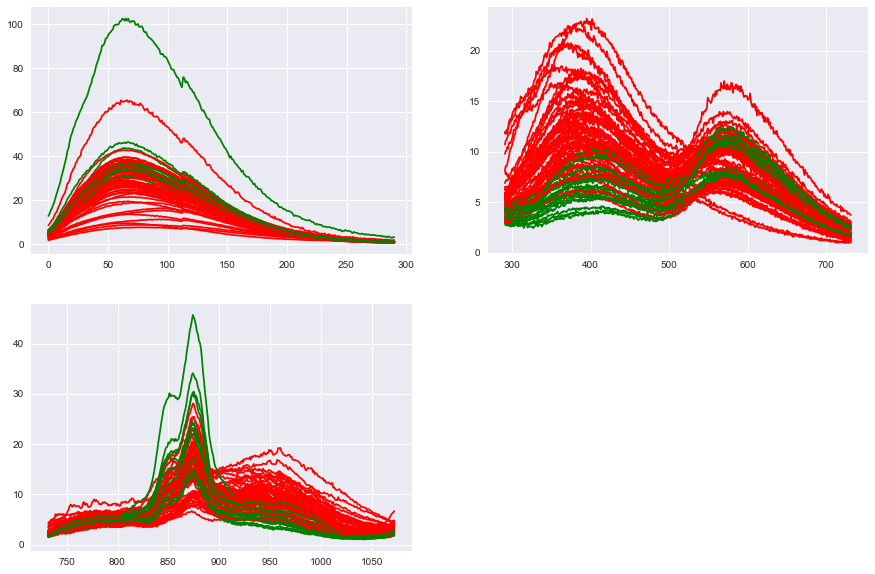

In [81]:
data_filt = filt_data(raw_data[raw_predictors], window=1, poly=0, slices=[291, 441, 341])

range1 = list(range(291))  # tryptophan
range2 = list(range(291, 291 + 441))  # Maillard reaction
range3 = list(range(291 + 441, 291 + 441 + 341))

fig = plt.figure(figsize=(15,10))


ax1 = plt.subplot(2, 2, 1)
for i in range(data_filt.shape[0]):
    plt.plot(range1, data_filt.T[range1, i], color=colors_lda[i])

ax2 = plt.subplot(2, 2, 2)
for i in range(data_filt.shape[0]):
    plt.plot(range2, data_filt.T[range2, i], color=colors_lda[i])

ax3 = plt.subplot(2, 2, 3)
for i in range(data_filt.shape[0]):
    plt.plot(range3, data_filt.T[range3, i], color=colors_lda[i])
print(data_filt.shape)

Select K best features for classification

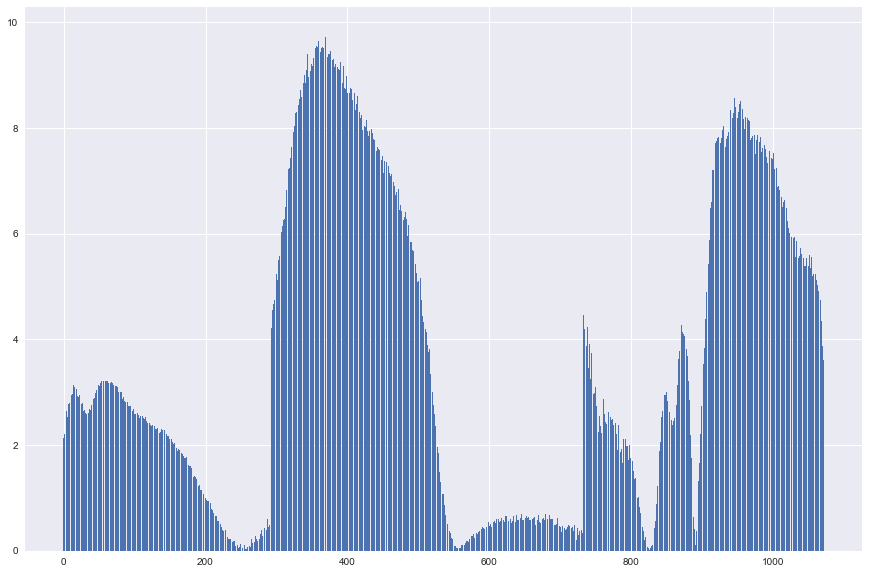

In [82]:
selector = SelectKBest(f_classif, k=5)
selector.fit(data_scaled[raw_predictors], raw_data["target"])

scores = -np.log10(selector.pvalues_)

plt.figure(figsize=(15, 10))
plt.bar(range(len(raw_predictors)), scores)
# plt.xticks(range(len(raw_predictors)), raw_predictors, rotation='vertical')
plt.show()

## Apply decomposition techniques to the data

PCA - principal component analysis (http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

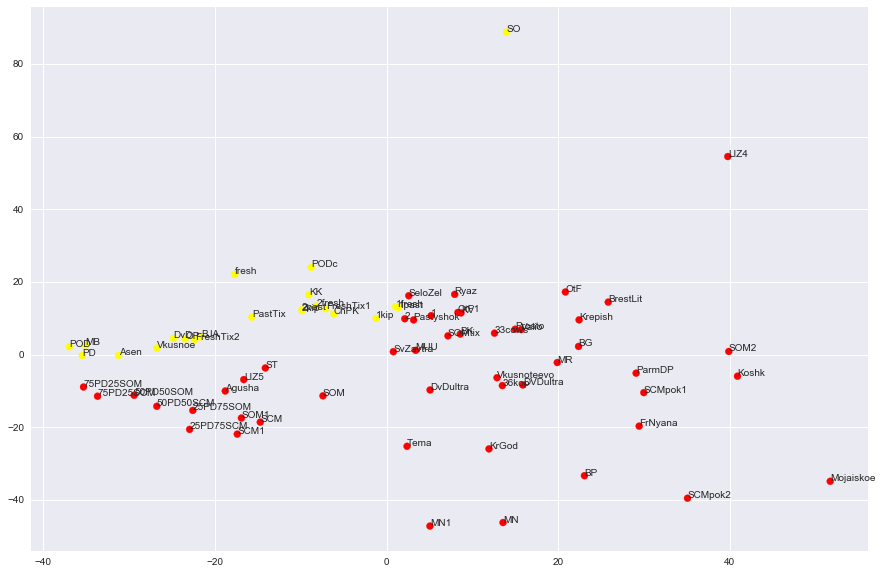

In [83]:
pca = PCA(n_components=10)
X = pca.fit_transform(data_scaled[raw_predictors], raw_data['target'])

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c = raw_data['target'], cmap='autumn')

for i, txt in enumerate(raw_data['l']):
    ax.annotate(txt, (X[i, 0], X[i, 1]))
fig.savefig('PCA_name.jpg')

(10, 1073)


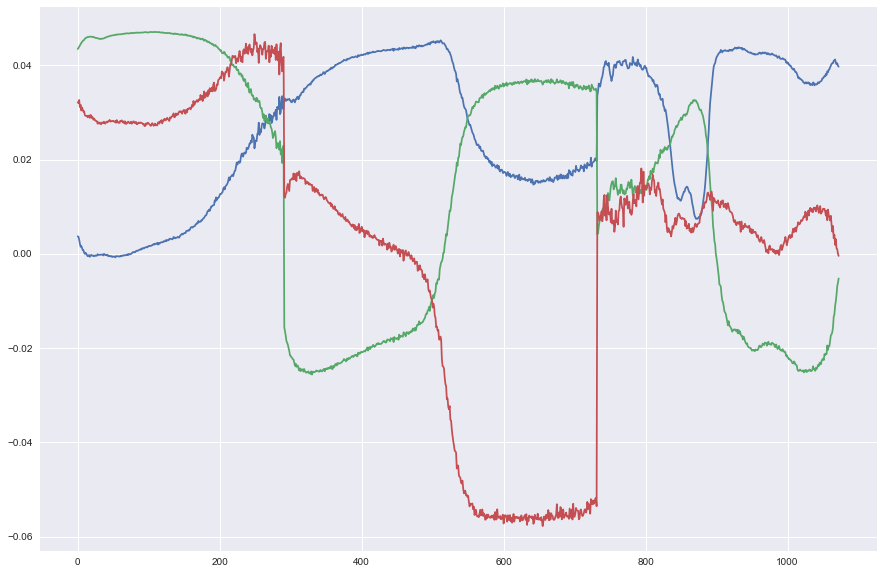

In [84]:
pca.get_params()

inv_tr_mat = np.dot(np.linalg.pinv(X), data_scaled[raw_predictors])
print(inv_tr_mat.shape)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
plt.plot(inv_tr_mat.T[:, 0:3])

LDA - linear discriminant analysis (http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)

C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


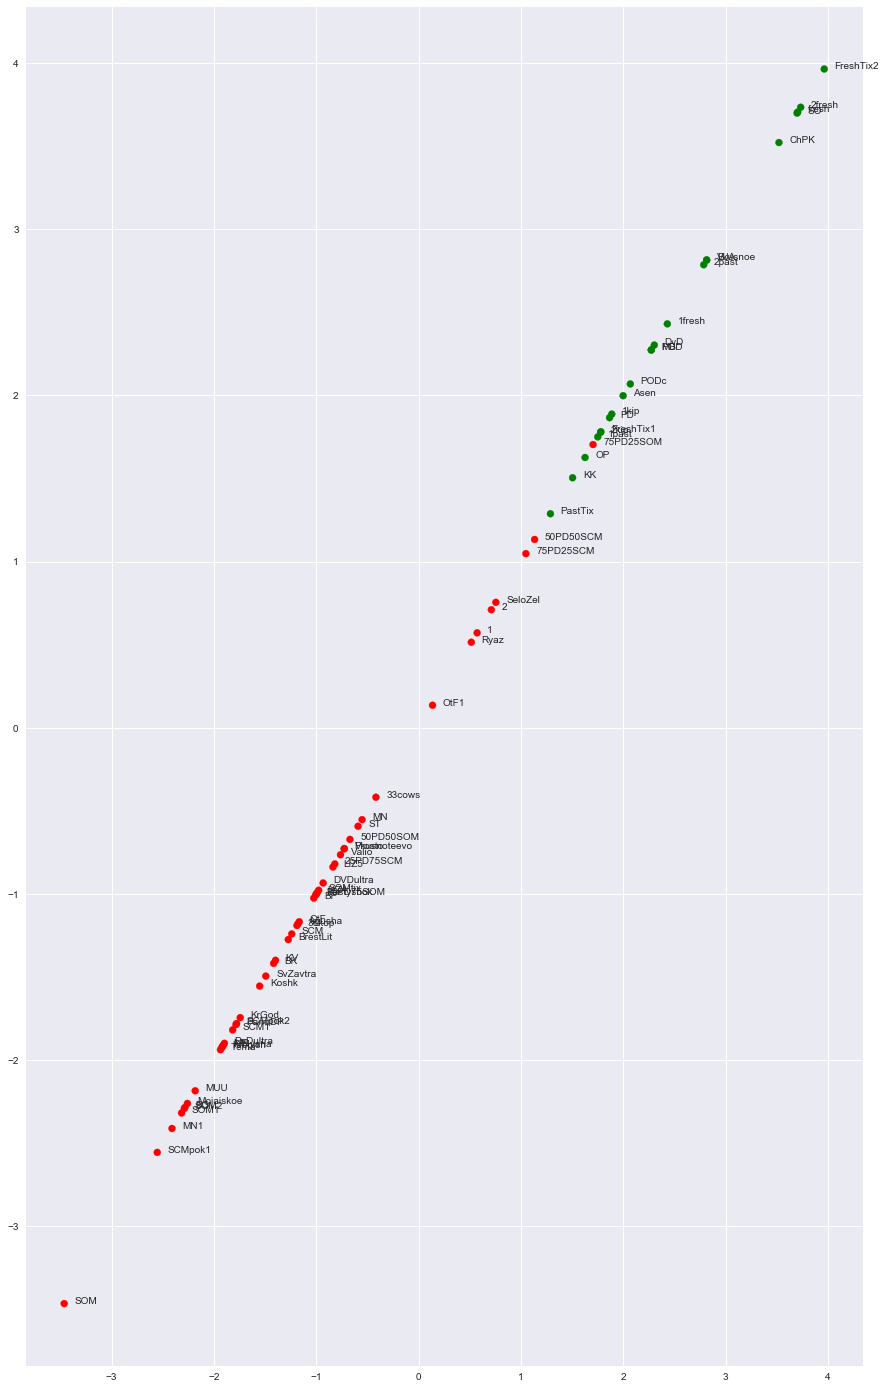

In [85]:
lda = LDA(n_components=None)
X_lda = pd.DataFrame(data = lda.fit_transform(data_scaled[raw_predictors], 1 * (raw_data['class (o)'] == 'positive')))

# colors for the lda plot considering heat-treatment ("g" - low, "r" - high)
colors_lda = list(map(lambda cond: 'g' if cond else 'r', raw_data['class (o)'] == 'positive'))

fig = plt.figure(figsize=(15, 25))
ax = plt.axes()
ax.scatter(X_lda.as_matrix().T[0], X_lda.as_matrix().T[0], c=colors_lda)
#ax.eventplot(X_lda.as_matrix().T, orientation='vertical', colors=colors_lda)

for i, txt in enumerate(raw_data['l'].as_matrix().T):
    ax.annotate(txt, (X_lda.as_matrix().T[0][i] + 0.1, X_lda.as_matrix().T[0][i]))
#sns.pairplot(X_lda, hue='class')
#plt.savefig('pairplot LDA_.jpg')